# Import and format data
## These  (until *) don't need to be run

In [ ]:
import pandas as pd
# names = ['Time','ID','Data']
read_file = pd.read_csv("candump-2021-02-08_150302.log", header = None)
read_file.to_csv (r'can_data.csv', index=None)
can_data = pd.read_csv("can_data.csv")

In [ ]:
can_data

### remove vcan0

In [ ]:
text = open("can_data.csv", "r")
text = ''.join([i for i in text]) \
    .replace("vcan0", ",")
x = open("can_data.csv","w")
x.writelines(text)
x.close()

### remove hash

In [ ]:
text = open("can_data.csv", "r")
text = ''.join([i for i in text]) \
    .replace("#", ",")
x = open("can_data.csv","w")
x.writelines(text)
x.close()

### remove parenthesis

In [ ]:
text = open("can_data.csv", "r")
text = ''.join([i for i in text]) \
    .replace("(", "")
x = open("can_data.csv","w")
x.writelines(text)
x.close()

text = open("can_data.csv", "r")
text = ''.join([i for i in text]) \
    .replace(")", "")
x = open("can_data.csv","w")
x.writelines(text)
x.close()

In [ ]:
can_data = pd.read_csv("can_data.csv",names = ['Time','ID','Data'])
can_data.to_csv (r'can_data.csv', index=None)
print(can_data)



# *

In [24]:
import pandas as pd
can_data = pd.read_csv("can_data.csv")
print(can_data)


                Time    ID              Data
0       0.000000e+00   NaN               NaN
1       1.612793e+09   039              0039
2       1.612793e+09   095  800007F400000017
3       1.612793e+09   1A4  0000000800000010
4       1.612793e+09   1AA  7FFF000000006711
...              ...   ...               ...
845498  1.612793e+09   244        00000001C0
845499  1.612793e+09   166          D0320018
845500  1.612793e+09   158  0000000000000019
845501  1.612793e+09   161  000005500108001C
845502  1.600000e+01   NaN               NaN

[845503 rows x 3 columns]


In [25]:
Time = can_data['Time']
Time = Time[1:-1]
Time = Time.reset_index(drop=True)

ID = can_data['ID']
ID = ID[1:-1]
ID = ID.reset_index(drop=True)

Data = can_data['Data']
Data = Data[1:-1]
Data = Data.reset_index(drop=True)




In [26]:
import numpy as np

def delta_time(Time): # calculates the time between two subsequent messages
    delta = np.zeros((Time.size))
    for x in range(Time.size-1):

       delta[x] = Time[x+1]-Time[x]

    return delta   

delta = delta_time(Time)


In [27]:
 def convert_from_hex(hex,output_type): # converts the data in hex from hexadecimal to decimal form
     out = np.zeros((hex.size))
     if output_type == 'dec':
        for x in range(hex.size):
            h_value = hex[x]
            out[x] = int(h_value,16)
     else:
        for x in range(hex.size):
            h_value = hex[x]
            binary[x] = bin(int(h_value, 16))[2:]

     return out


data = convert_from_hex(Data,'dec')
id = convert_from_hex(ID,'dec')

In [28]:
 def convert_to_bin(hex): # converts the data in hex from hexadecimal to decimal form
     binary = np.zeros((hex.size))

     for x in range(hex.size):
         h_value = hex[x]
         binary[x] = bin(int(h_value, 16))[2:]
     return binary


data = convert_from_hex(Data)
id = convert_to_bin(ID)

TypeError: convert_from_hex() missing 1 required positional argument: 'output_type'

In [119]:
id[4]

110110000.0

## Normalize data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data = data.reshape(-1, 1)
#data = scaler.fit_transform(data)
id = id.reshape(-1, 1)
id = scaler.fit_transform(id)

## Visualize data

In [ ]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(Time[0:10000],data[0:10000],'o')
plt.xlabel('Time')
plt.ylabel('Data')

plt.figure()
plt.plot(Time[0:10000],id[0:10000],'o')
plt.xlabel('Time')
plt.ylabel('ID')

plt.figure()
plt.plot(data[0:10000],id[0:10000],'o')
plt.xlabel('Data')
plt.ylabel('ID')




In [ ]:
steps = range(Time.size)
plt.figure()
plt.plot(steps[0:100000],delta[0:100000])

In [ ]:
def sort_IDs(id): # returns groups of indices of unique ids in list 

    idx_sort = np.argsort(id)
    sorted_ids = id[idx_sort]
    vals, idx_start, count = np.unique(sorted_ids, return_counts=True, return_index=True)
    indices = np.split(idx_sort, idx_start[1:])

    return indices





In [ ]:
transposed_id = np.transpose(id) # not sure why it needs to be transposed but it doesn't work otherwise
indices = sort_IDs(transposed_id[0][:])




In [ ]:
def get_data_stream(indices,data): # collects the unique ids with their respective data streams

    num_unique_ids = len(indices)
    all_ids = []
    for x in range(num_unique_ids):
         
         id_data = data[indices[x]]
         all_ids.append(id_data)

    return all_ids

all_id_data = get_data_stream(indices,data)  

In [ ]:
 # combines each unique id with its data stream in a matrix where the ID is in the first row, and its data stream is (ordered)
 # in the column under it. (one column = ID: data1,data2,..). column length = max data length, if data doesn't fill upp all rows they are filled with nan. 
def combine_ids_data(indices,id,all_id_data):
    i = -1
    ids_and_data = np.ones((np.max([len(pi) for pi in all_id_data])+1,len(all_id_data)))*np.nan 

    for x in indices:
        i = i+ 1
        index = indices[i] 
        index = index[0] # only save first one in group
        ID = id[index]

        data_stream = all_id_data[i]
        data_stream = data_stream[:,0] 
        ids_and_data[0,i] = ID
        ids_and_data[1:len(data_stream)+1,i] = data_stream

    return ids_and_data

d = combine_ids_data(indices,id,all_id_data)

In [ ]:

print(f'Number of individual IDs in the full sequence = {len(d[0,:])}')
print(f'Maximum number of data packets per ID = {np.max([len(pi) for pi in all_id_data])}')

In [ ]:
plt.plot(np.arange(100),d[0:100,0],'-o')

# Copied

In [38]:
# split a univariate sequence into samples
from numpy import array


def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [39]:
def remove_nans(input): # remove nans from data stream column
    input_nans = np.isnan(input) 
    not_nan = ~ input_nans
    clean_input = input[not_nan]
    return clean_input

In [58]:
from numpy import array


def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
		# find the end of this pattern
        end_ix = i + n_steps
        end_iy = end_ix + n_steps 
		# check if we are beyond the sequence
        if end_iy > len(sequence)-1:
            break
		# gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_iy]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [76]:
n_steps = 5
seq = remove_nans(d[:,0])   

nTrain = round(0.9*len(seq))
nTest = len(seq)-nTrain
xTrain = seq[0:nTrain]
xTest = seq[nTrain:len(seq)]

X_train, y_train = split_sequence(xTrain, n_steps)
X_test, y_test = split_sequence(xTest, n_steps)



In [78]:
X_test.shape

(2835, 5)

In [97]:
! pip install tensorflow
! pip install keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

'pip' is not recognized as an internal or external command,
operable program or batch file.
'pip' is not recognized as an internal or external command,
operable program or batch file.


In [75]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

In [2]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

NameError: name 'n_steps' is not defined

In [7]:

# define model (autoencoder)
n_steps = 5
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps,1)))
print(model.output_shape)
model.add(RepeatVector(n_steps))
print(model.output_shape)
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')


(None, 100)
(None, 5, 100)


In [102]:
# canolo
model = Sequential()

# Encoder
model.add(Dense(256, activation='tanh', input_shape=(n_steps,1)))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(RepeatVector(n_steps))
model.add(LSTM(128))
model.add(RepeatVector(n_steps))

# Decoder
model.add(LSTM(128))
model.add(RepeatVector(n_steps))
model.add(LSTM(128, return_sequences=True))
model.add(Dense(256, activation= 'sigmoid'))
model.add(Dense(1)) # they don't mention this in the article but dimensions are wrong otherwise

model.compile(optimizer='adam', loss='BinaryCrossentropy')
model.summary()




Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 15, 256)           512       
_________________________________________________________________
dropout_36 (Dropout)         (None, 15, 256)           0         
_________________________________________________________________
lstm_119 (LSTM)              (None, 128)               197120    
_________________________________________________________________
repeat_vector_88 (RepeatVect (None, 15, 128)           0         
_________________________________________________________________
lstm_120 (LSTM)              (None, 128)               131584    
_________________________________________________________________
repeat_vector_89 (RepeatVect (None, 15, 128)           0         
_________________________________________________________________
lstm_121 (LSTM)              (None, 128)             

In [80]:
nums = array([1,2,3,4,5,6,7,8,9,10,11,12,13,141,5])
test_nums = array([1, 1, 1, 2, 6, 2, 4, 2, 3, 8, 7, 6, 2, 3, 14])
rev_nums = nums[::-1]
rev_test_nums = test_nums[::-1]
n_features = 1
#X_test = test_nums.reshape((test_nums.shape[0], test_nums.shape[1], n_features))
#y_test = rev_test_nums.reshape((rev_test_nums.shape[0], rev_test_nums.shape[1], n_features))
#X_train = nums.reshape((nums.shape[0], nums.shape[1], n_features))
#y_train = rev_nums.reshape((rev_nums.shape[0], rev_nums.shape[1], n_features))
X_test = test_nums.reshape((1, 15, n_features))
y_test = rev_test_nums.reshape((1, 15, n_features))
X_train = nums.reshape((1, 15, n_features))
y_train = rev_nums.reshape((1, 15, n_features))
n_steps = 15

Epoch 1/500
1/1 - 0s - loss: 243.7142 - val_loss: 63.7565
Epoch 2/500
1/1 - 0s - loss: 243.7142 - val_loss: 63.7565
Epoch 3/500
1/1 - 0s - loss: 243.7142 - val_loss: 63.7565
Epoch 4/500
1/1 - 0s - loss: 243.7142 - val_loss: 63.7565
Epoch 5/500
1/1 - 0s - loss: 243.7142 - val_loss: 63.7565
Epoch 6/500
1/1 - 0s - loss: 243.7142 - val_loss: 63.7565
Epoch 7/500
1/1 - 0s - loss: 243.7142 - val_loss: 63.7565
Epoch 8/500
1/1 - 0s - loss: 243.7142 - val_loss: 63.7565
Epoch 9/500
1/1 - 0s - loss: 243.7142 - val_loss: 63.7565
Epoch 10/500
1/1 - 0s - loss: 243.7142 - val_loss: 63.7565
Epoch 11/500
1/1 - 0s - loss: 243.7142 - val_loss: 63.7565
Epoch 12/500
1/1 - 0s - loss: 243.7142 - val_loss: 63.7565
Epoch 13/500
1/1 - 0s - loss: 243.7142 - val_loss: 63.7565
Epoch 14/500
1/1 - 0s - loss: 243.7142 - val_loss: 63.7565
Epoch 15/500
1/1 - 0s - loss: 243.7142 - val_loss: 63.7565
Epoch 16/500
1/1 - 0s - loss: 243.7142 - val_loss: 63.7565
Epoch 17/500
1/1 - 0s - loss: 243.7142 - val_loss: 63.7565
Epoch 

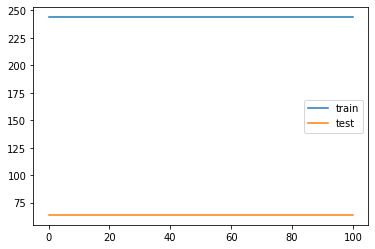

In [104]:
from matplotlib import pyplot
# design network
# fit network
# batch size should be 128
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=100)

history = model.fit(X_train, y_train, epochs=500, batch_size=15, validation_data=(X_test, y_test), verbose=2, shuffle=False,callbacks=[es])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [99]:

# demonstrate prediction
x_input = array([1,2,3,4,5,6,7,8,9,10,11,12,13,141,5])
x_input = x_input.reshape(1,15,1)
#print(x_input)
#x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)


[[[7.2438445]
  [8.873718 ]
  [9.1790085]
  [9.23379  ]
  [9.244105 ]
  [9.246179 ]
  [9.246569 ]
  [9.24657  ]
  [9.246474 ]
  [9.246359 ]
  [9.24625  ]
  [9.246154 ]
  [9.246072 ]
  [9.246004 ]
  [9.245945 ]]]


In [133]:
print( X[56,1,:]-yhat)
print( X[56,1,:])

IndexError: index 56 is out of bounds for axis 0 with size 1

In [ ]:
train_X = X
train_y = y
test_X = X[50:55,1,:]
test_y = X[56,1,:]
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import LSTM
# prepare sequence
length = 5
seq = array([i/float(length) for i in range(length)])
#X = seq.reshape(1, length, 1)
#y = seq.reshape(1, length, 1)
# define LSTM configuration
n_neurons = length
n_batch = 1
n_epoch = 1000
# create LSTM
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(length, 1), return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
# train LSTM
model.fit(X_train, y_train, epochs=n_epoch, batch_size=n_batch, verbose=2)
# evaluate
result = model.predict(X_test, batch_size=n_batch, verbose=0)
for value in result[0,:,0]:
 print('%.1f' % value)

## ^copied